In [12]:
#Really need these
import pandas as pd 
import numpy as np
from numpy import *

#Handy for debugging
import gc
import time
import warnings
import os

#Date stuff
from datetime import datetime
from datetime import timedelta

#Nice graphing tools
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.offline as py
import plotly.tools as tls
import plotly.graph_objs as go
import plotly.tools as tls

#Machine learning tools
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error

## Performance measures
from sklearn.metrics import mean_squared_error

In [13]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/my_research/2021_GEARS/water_quality/data'

os.chdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Jiting data prep:

In [14]:
# Processing data, window is the window size, station is for a specific observation station
def join_discharge_feature(df_discharge, df_station, window:int):
  # process the data
  # new_data_columns = get_new_columns(df_discharge, window)  # anew column
  new_data_columns = ['flow_max', 'flow_min', 'flow_mean', 'flow_aggregate']
  df_new = pd.DataFrame(columns=new_data_columns)  

  for row in range(df_station.shape[0]):
    # the day for Chlorophyll
    current_chl = df_station.iloc[row, 0]
    date_start = current_chl - timedelta(days=window)

    # Process data by time, select days including this day and previous "window" days
    df_window = df_discharge[(df_discharge['Date'] > date_start) & (df_discharge['Date'] <= current_chl)]
    # df_interval = df_discharge[(df_discharge['Date'] > today_chl) & (df_discharge['Date'] <= tomorrow_chl)]
    
    # find the feature of the water flow in the interval
    flow_max = df_window['flow (cfs)'].max()
    flow_min = df_window['flow (cfs)'].min()
    flow_mean = np.mean(df_window['flow (cfs)'])
    flow_aggregate = np.sum(df_window['flow (cfs)'])
    features = [flow_max, flow_min, flow_mean, flow_aggregate]

    # transform into a piece of data
    df_row = pd.DataFrame(columns=new_data_columns)
    df_row.loc[0] = features
    df_new = df_new.append(df_row)

  # merge the data of hydrology and Chlorophyll into one dataframe
  df_new = df_new.reset_index(drop=True)

  df_station.drop(['Date'], axis=1, inplace=True)
  df_station = df_station.reset_index(drop=True)

  df_final = pd.concat([df_new, df_station], axis=1)
  # print(df_new.shape, df_station.shape, df_final.shape)

  return df_final

In [15]:
# wavelet transform
# https://www.jianshu.com/p/56733f6c0a10
# https://stackoverflow.com/questions/45051106/multilevel-partial-wavelet-reconstruction-with-pywavelets

def wavlet_transform(df_chla, feature_name, wavelet_type, level_num):
  # the function 'wrcoef' does not have implementation in the pywt library
  # decompose to get the wavelet tree structure, and use wavedec for multi-layer decomposition
  wave = pywt.wavedec(df_chla[feature_name], wavelet_type, level=level_num)
  wave_length = len(df_chla[feature_name])

  # wavelet reconstruction
  for i in range(1, level_num+1+1):
    # loop for reconstruction in different frequency range
    col_name = feature_name + '_d' + str(i)
    if i == level_num+1:
      col_name = feature_name +  '_a' + str(i-1) # 'a4'

    select_column = [0] * (level_num+1) # [0, 0, 0, 0, 0]
    select_column[level_num+1-i] = 1 # [0, 0, 0, 0, 1]

    # append to the dataframe
    df_chla[col_name] = pywt.waverec(np.multiply(wave, select_column).tolist(), wavelet_type)[:wave_length]

  return df_chla

# plot the decomposed chlorophyll wavelet variables
def plot_signal_decomp(df_chla, feature_name, level_num):
  # plot
  data = df_chla[feature_name]
  X = range(len(data))
  plt.figure(figsize=(12, 12))

  plt.subplot(611)
  plt.plot(X, data)
  plt.title('original signal')

  plt.subplot(612)
  plt.plot(X, df_chla[feature_name + ' a' + str(level_num)])
  plt.title('approximated component in level ' + str(level_num))

  for i in range(1, level_num+1):
    # loop for reconstruction in different frequency range
    cur_level = level_num+1-i # first d4, and then d3...
    col_name = feature_name + ' d' + str(cur_level)

    plt.subplot(612+i)
    plt.plot(X, df_chla[col_name])
    plt.title('detailed component in level ' + str(cur_level))

  plt.tight_layout()
  plt.show()

In [16]:
# scaler function
from sklearn.preprocessing import MinMaxScaler

def scale_data(df, col_name):
  # find that column by name
  data = df[col_name].values
  data = data.reshape(len(data), 1)

  # scaler transform
  scaler = MinMaxScaler(feature_range=(0,1))
  data = scaler.fit_transform(data).reshape(len(data),) 
    
  df[col_name] = data

  return df, scaler

In [17]:
# shift
def shift_row(df, known_month, predict_col_name, features_use_current_observation):
  # move upward for y label
  df.rename(columns={predict_col_name: 'chla_for_predict'}, inplace=True)
  df['chla_for_predict'] = df['chla_for_predict'].shift(-1)

  # features_use_current_observation 
  for feature in features_use_current_observation:
    df[feature] = df[feature].shift(-1)

  # if use the past two months' data for prediction
  if known_month is not 0:
    columns = df.columns
    for col in columns:
      if col is not 'chla_for_predict' and col not in features_use_current_observation:
        df[col+'_last'] = df[col].shift(1)

  # drop the row having null value
  df.dropna(axis=0, how='any', inplace=True)
  # df = df.reset_index(drop=True)

  return df

In [18]:
# wavlet analysis
# http://users.rowan.edu/~polikar/WTpart1.html
# https://pywavelets.readthedocs.io/en/latest/ref/dwt-discrete-wavelet-transform.html

import pywt

def data_prep_Jiting(df_chla, **kwargs):
  '''
  kwargs = {
    "station_Num": 160, # You can choose to leave a station, if there is no such parameter, all station data will be left
    "discharge_data": df_river_discharge,
    "discharge_window": 2,
    "wav_dict": [ {'wav_col': 'TotalChla', 'wavelet_type': 'db4', 'level_num': 4} ],
    "cols_to_keep": ['Season', 'YSI_Temp', 'YSI_Salinity', 'YSI_DO', 'YSI_pH', 'POC', 'NOx', "NH4", 'PO4', 'TotalChla'], # 一定包含要wavlet和one_hot_encode的列
    "one_hot_encoding_cols": ['season']
  }
  '''
  columns = []
  # If there is station_Num in the key value
  if "station_Num" in kwargs.keys():
    df_chla = df_chla[ df_chla['Station'] == kwargs["station_Num"] ]
    df_chla.drop(['Station'], axis=1, inplace=True)

  # If there is a water flow df, then construct the feature: 1. Choose whether to add the water flow of the previous few days according to the window 2. The interval water flow max min average
  if "discharge_data" in kwargs.keys() and 'discharge_window' in kwargs.keys():
    # if/elif/else cannot involve changes in variable scope, that is to say, variables in their code blocks can also be accessed externally
    df_chla = join_discharge_feature(kwargs["discharge_data"], df_chla, kwargs["discharge_window"])

  # Keep the specified feature, otherwise it is not easy to pick out after the wavlet
  if "cols_to_keep" in kwargs.keys():
    df_chla = df_chla[kwargs['cols_to_keep']]
    # Pave the way for subsequent scale
    columns = kwargs['cols_to_keep']


  # if we need the feature by wavelet
  if "wav_dict" in kwargs.keys():
    for dict_member in kwargs['wav_dict']:
      df_chla = wavlet_transform(df_chla, dict_member['wav_col'], dict_member['wavelet_type'], dict_member['level_num'])
      # plot_signal_decomp(df_chla, dict_member['wav_col'], dict_member['level_num'])
      # Pave the way for subsequent scale
      columns.remove(dict_member['wav_col'])
  else:
    # if donot need wavelet features，Then you need to keep a column of y as x, so after shifting, there are chla of the previous two weeks
    print("reserve a column of chla for future shifting:", kwargs['shift_params']['predict_col_name'])
    df_chla['chla_x'] = df_chla[kwargs['shift_params']['predict_col_name']]
    columns.remove(kwargs['shift_params']['predict_col_name'])

  # one hot encoding
  if "one_hot_encoding_cols" in kwargs.keys():
    df_chla = pd.get_dummies(df_chla, columns=kwargs['one_hot_encoding_cols'], drop_first=True)
    # Pave the way for subsequent scale
    columns.remove(kwargs['one_hot_encoding_cols'])

  # normalization processing does not process the column of wavlet and the column after wavlet; does not process one_hot_encoding_cols
  for col in columns:
    df_chla, scaler = scale_data(df_chla, col)

  # row shift processing
  if "shift_params" in kwargs.keys():
    shift_params_dict = kwargs['shift_params']
    # Shift processing according to parameters
    df_chla = shift_row(df_chla, shift_params_dict['known_month'], shift_params_dict['predict_col_name'], 
                        shift_params_dict['features_use_current_observation'])

  return df_chla

## Jiting Feature Importance

In [19]:
# Import the random forest model and accuracy_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def get_feature_importance(df_data):
  X = df_data.drop('chla_for_predict',axis=1)
  y = df_data['chla_for_predict']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

  # This line instantiates the model. 
  rf = RandomForestRegressor() 

  # Fit the model on your training data.
  rf.fit(X_train, y_train) 
  y_predict = rf.predict(X_test)

  feature_importances = pd.DataFrame(rf.feature_importances_, index = X_train.columns,
                  columns=['importance']).sort_values('importance', ascending=False)
  
  return feature_importances

## Jiting Data Input for Models

In [20]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# split training and validation sets
def split_data(df_build):
  length = int(0.8 * df_build.shape[0]) + 1

  y_train = np.array(df_build[:length]['chla_for_predict'], dtype='float32')
  x_train = np.array(df_build[:length].drop(['chla_for_predict'], axis=1), dtype='float32')

  y_test = np.array(df_build[length:]['chla_for_predict'], dtype='float32')
  x_test = np.array(df_build[length:].drop(['chla_for_predict'], axis=1), dtype='float32')

  y_train = np.reshape(y_train, (len(y_train),-1))
  y_test = np.reshape(y_test, (len(y_test),-1))

  return x_train, y_train, x_test, y_test

# obtain dataLoader from data array
def get_data_loader(x_train, y_train, x_test, y_test):
  # construct dataLoader
  x_train_tensor, y_train_tensor = torch.from_numpy(x_train), torch.from_numpy(y_train)
  x_test_tensor, y_test_tensor = torch.from_numpy(x_test), torch.from_numpy(y_test)
  # y_train = y_train.unsqueeeze(-1)

  train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
  test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

  train_loader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=False, num_workers=2)
  test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, num_workers=2)

  return train_loader, test_loader


## Jiting Model (ANN & LSTM)

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ANN(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(ANN, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size) 
    self.fc2 = nn.Linear(hidden_size, num_classes)  
  
  def forward(self, x):
    out = self.fc1(x)
    out = F.relu(out)
    out = self.fc2(out)

    return out

In [22]:
def train_ANN_Model(train_loader, input_layer_num, hidden_layer_num, epoch_num):
  # Instatiating the model
  model = ANN(input_layer_num, hidden_layer_num, 1) 

  # Defying loss function and optimizer
  loss_function = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(model.parameters())

  # save the loss of each training epoch
  loss_set = []

  # Training loop for each epoch
  for epoch in range(epoch_num):
    total_loss = 0
    for x, y in train_loader: 
      # eliminate errors
      optimizer.zero_grad()

      # forward + loss + backward + optimise (update weights)
      output = model(x)
      loss = loss_function(output, y)
      loss.backward()
      optimizer.step()

      total_loss += loss.item()
    
    # output and record the loss of this round
    # print("Epoch: %d, Loss: %4.2f" % (epoch, total_loss) )

    loss_set.append(total_loss)

  return model, loss_set

In [23]:
def get_train_and_test_result(model, train_loader, test_loader):
  model.eval()
  # Computing the model accuracy on the test set
  y_train_res = []
  for x, y in train_loader:
    output = model(x)
    y_train_res.append(output.item())

  # Computing the model accuracy on the test set
  y_test_res = []
  for x, y in test_loader:
    output = model(x)
    y_test_res.append(output.item())

  y_test_res = [(x > 0) * x for x in y_test_res]

  return y_train_res, y_test_res

In [24]:
def plot_line_chart_for_train_or_test_set(y, y_res):
  # plotting
  plt.figure(figsize=(12, 4))
  plt.plot(np.array(y), label='True')
  plt.plot(y_res, label='Model_Output')
  plt.legend(prop={'family' : 'Times New Roman', 'size': 12})
  plt.show()

In [25]:
def print_error(y_truth, y_test_res):
  # MSE
  err_mse = mean_squared_error(y_truth, y_test_res)
  print("MSE: ", err_mse)

  # RMSE
  err_rmse = np.sqrt(err_mse)
  print("RMSE: ", err_rmse)

  # MAPE
  MAPE = np.mean(np.abs((y_truth - y_test_res) / y_truth)) * 100
  print("MAPE: ", MAPE)


In [26]:
def pipeline_ann_Jiting(df_data):
  # split the dataframe
  x_train, y_train, x_test, y_test = split_data(df_data)

  # obtain data Loader
  train_loader, test_loader = get_data_loader(x_train, y_train, x_test, y_test)

  # the number of nodes in the hidden layer
  input_layer_num = x_train.shape[1]

  loss_temp = 1000000000

  # key super-parameter
  best_res_hidden_layer = 0

  for hidden_layer_num in range(input_layer_num//2, input_layer_num*2, 2):
    model, loss = train_ANN_Model(train_loader, input_layer_num, hidden_layer_num, 20)
    if loss[-1] < loss_temp:
      loss_temp = loss[-1]
      # print("hidden_layer: ", hidden_layer_num, "epoch_num: ", epoch_num)
      best_res_hidden_layer = hidden_layer_num

      model.eval()
      y_train_res, y_test_res = get_train_and_test_result(model, train_loader, test_loader)

  return best_res_hidden_layer, y_train, y_train_res, y_test, y_test_res

In [27]:
import sys
def run_ann(station_num):
  print("Station Number ", station_num, ": ")
  df_junan_modmon_data = pd.read_csv('./Junan Modmon Data/new_interpolated_Station_' + station_num + '_Depth_1_.csv')

  # process the 'Date'
  df_junan_modmon_data['Date'] = [datetime.strptime(date, '%Y-%m-%d').date() for date in df_junan_modmon_data['Date'].astype(str).values.tolist()]

  # keep testing set
  df_save_for_plot = df_junan_modmon_data[df_junan_modmon_data['Date'] >= datetime.strptime("2014-3-25", '%Y-%m-%d').date()]
  df_save_for_plot = df_save_for_plot[['Date', 'TotalChla']]
  df_save_for_plot = df_save_for_plot.rename(columns={"TotalChla": "Groud_Truth"})
  df_save_for_plot = df_save_for_plot.reset_index(drop=True)

  # keep these columns
  order = ['YSI_Temp', 'YSI_Salinity', 'YSI_DO', 'YSI_pH', 'POC', 'NOx', "NH4", 'PO4', 'TotalChla', 'ACC_WSPD_2',	'ACC_PRES_3',	'ACC_ATMP_5', 'ACC_FLOW_5']
  df_junan_modmon_data = df_junan_modmon_data[order]

  kwargs_modmon_all_feature = {
    "wav_dict": [ {'wav_col': 'TotalChla', 'wavelet_type': 'db4', 'level_num': 4} ],
    "cols_to_keep": ['YSI_Temp', 'YSI_Salinity', 'YSI_DO', 'YSI_pH', 'POC', 'NOx', "NH4", 'PO4', 'TotalChla', 'ACC_WSPD_2',	'ACC_PRES_3',	'ACC_ATMP_5', 'ACC_FLOW_5'], 
    # acc_flow vec_acc_windspedd vec_acc_wind_direction acc_temperature acc_
    # pressure?
    # "one_hot_encoding_cols": ['Season'],
    "shift_params": {'known_month': 1, 'predict_col_name': 'TotalChla', 'features_use_current_observation': ['ACC_WSPD_2', 'ACC_PRES_3',	'ACC_ATMP_5', 'ACC_FLOW_5']}
    # known_month parameter is 1 for 2 months, 0 for the past month
  }

  df_modmon_junan = data_prep_Jiting(df_junan_modmon_data, **kwargs_modmon_all_feature)

  # feature importance
  df_import = get_feature_importance(df_modmon_junan)
  columns = df_import.index.to_list()

  curr_mse = sys.maxsize

  length = len(columns)
  for vec_len in range((int)(0.5*length), length+1, 3):
    cols = columns[:vec_len] + ["chla_for_predict"]
    df_data = df_modmon_junan[cols] 

    hidden_layer, y_train, y_train_res, y_test, y_test_res = pipeline_ann_Jiting(df_data)
    err_mse = mean_squared_error(y_test, y_test_res)

    if err_mse < curr_mse:
      curr_mse = err_mse
      save_hidden_layer, save_y_train, save_y_train_res, save_y_test, save_y_test_res = hidden_layer, y_train, y_train_res, y_test, y_test_res
      best_length = vec_len


  # output the results
  print("hidden_layer: ", save_hidden_layer)
  print_error(save_y_test, save_y_test_res)
  print("Best length: ", best_length)

  # keep results
  df_test_result = pd.DataFrame(save_y_test_res, columns=['Prediction'])
  df_test_result = df_test_result.reset_index(drop=True)

  plot_line_chart_for_train_or_test_set(save_y_train, save_y_train_res)
  
  plot_line_chart_for_train_or_test_set(save_y_test, save_y_test_res)

  df_save_csv = pd.concat([df_save_for_plot, df_test_result], axis=1)
  df_save_csv.to_csv('./Result/Wavelet_ANN/Station_' + station_num + '_Depth_1_.csv')
  

In [28]:
import sys
def run_ann_with_only_wavelets(station_num):
  print("Station Number ", station_num, ": ")
  df_junan_modmon_data = pd.read_csv('./Junan Modmon Data/new_interpolated_Station_' + station_num + '_Depth_1_.csv')

  # process the data
  df_junan_modmon_data['Date'] = [datetime.strptime(date, '%Y-%m-%d').date() for date in df_junan_modmon_data['Date'].astype(str).values.tolist()]

  # keep testing set
  df_save_for_plot = df_junan_modmon_data[df_junan_modmon_data['Date'] >= datetime.strptime("2014-3-25", '%Y-%m-%d').date()]
  df_save_for_plot = df_save_for_plot[['Date', 'TotalChla']]
  df_save_for_plot = df_save_for_plot.rename(columns={"TotalChla": "Groud_Truth"})
  df_save_for_plot = df_save_for_plot.reset_index(drop=True)

  # keep these columns
  order = ['YSI_Temp', 'YSI_Salinity', 'YSI_DO', 'YSI_pH', 'POC', 'NOx', "NH4", 'PO4', 'TotalChla', 'ACC_WSPD_2',	'ACC_PRES_3',	'ACC_ATMP_5', 'ACC_FLOW_5']
  df_junan_modmon_data = df_junan_modmon_data[order]

  kwargs_modmon_only_wavelet = {
    "wav_dict": [ {'wav_col': 'TotalChla', 'wavelet_type': 'db4', 'level_num': 4} ],
    "cols_to_keep": ['TotalChla'], # keep the column of wavelet and one-hot encoding
    # acc_flow vec_acc_windspedd vec_acc_wind_direction acc_temperature acc_
    # pressure?
    # "one_hot_encoding_cols": ['Season'],
    "shift_params": {'known_month': 1, 'predict_col_name': 'TotalChla', 'features_use_current_observation': []}
    # known_month parameter is 1 for 2 months, 0 for the past month
  } 

  df_modmon_junan = data_prep_Jiting(df_junan_modmon_data, **kwargs_modmon_only_wavelet)
  print(df_modmon_junan.columns)

  hidden_layer, y_train, y_train_res, y_test, y_test_res = pipeline_ann_Jiting(df_modmon_junan)
    
  # output result
  print("hidden_layer: ", hidden_layer)
  print_error(y_test, y_test_res)

  # keep result
  df_test_result = pd.DataFrame(y_test_res, columns=['Prediction'])
  df_test_result = df_test_result.reset_index(drop=True)

  plot_line_chart_for_train_or_test_set(y_train, y_train_res)
  
  plot_line_chart_for_train_or_test_set(y_test, y_test_res)

  df_save_csv = pd.concat([df_save_for_plot, df_test_result], axis=1)
  df_save_csv.to_csv('./Result/Only_Wavelet_ANN/Station_' + station_num + '_Depth_1_.csv')
  

In [29]:
kwargs_modmon_only_wavelet = {
  "wav_dict": [ {'wav_col': 'TotalChla', 'wavelet_type': 'db4', 'level_num': 4} ],
  "cols_to_keep": ['TotalChla'], # keep the column of wavelet and one-hot encoding
  # acc_flow vec_acc_windspedd vec_acc_wind_direction acc_temperature acc_
  # pressure?
  # "one_hot_encoding_cols": ['Season'],
  "shift_params": {'known_month': 1, 'predict_col_name': 'TotalChla', 'features_use_current_observation': []}
  # known_month parameter is 1 for 2 months, 0 for the past month
} 

# this for no wind parameter
kwargs_modmon_without_wind = {
  "wav_dict": [ {'wav_col': 'TotalChla', 'wavelet_type': 'db4', 'level_num': 4} ],
  "cols_to_keep": ['YSI_Temp', 'YSI_Salinity', 'YSI_DO', 'YSI_pH', 'POC', 'NOx', "NH4", 'PO4', 'TotalChla', 'ACC_FLOW_5'], 
  # acc_flow vec_acc_windspedd vec_acc_wind_direction acc_temperature acc_
  # pressure?
  # "one_hot_encoding_cols": ['Season'],
  "shift_params": {'known_month': 1, 'predict_col_name': 'TotalChla', 'features_use_current_observation': ['ACC_FLOW_5']}
  # known_month parameter is 1 for 2 months, 0 for the past month
}

kwargs_modmon_all_feature = {
  "wav_dict": [ {'wav_col': 'TotalChla', 'wavelet_type': 'db4', 'level_num': 4} ],
  "cols_to_keep": ['YSI_Temp', 'YSI_Salinity', 'YSI_DO', 'YSI_pH', 'POC', 'NOx', "NH4", 'PO4', 'TotalChla', 'ACC_WSPD_2',	'ACC_PRES_3',	'ACC_ATMP_5', 'ACC_FLOW_5'],
  # acc_flow vec_acc_windspedd vec_acc_wind_direction acc_temperature acc_
  # pressure?
  # "one_hot_encoding_cols": ['Season'],
  "shift_params": {'known_month': 1, 'predict_col_name': 'TotalChla', 'features_use_current_observation': ['ACC_WSPD_2', 'ACC_PRES_3',	'ACC_ATMP_5', 'ACC_FLOW_5']}
  # known_month parameter is 1 for 2 months, 0 for the past month
}



Station Number  0 : 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



hidden_layer:  53
MSE:  1.2877746431976795
RMSE:  1.1348015875903943
MAPE:  181.05389377615572
Best length:  30


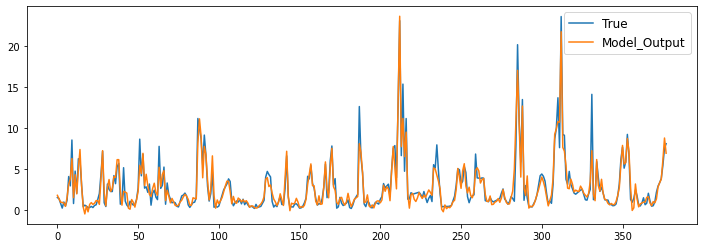

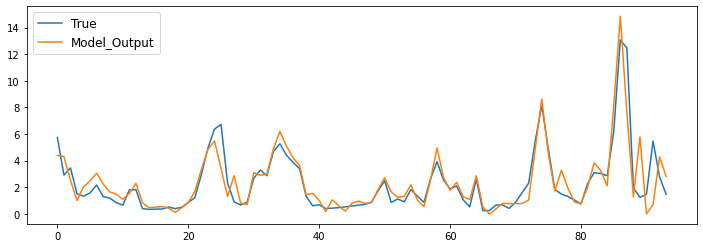

Station Number  20 : 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcb7b5da200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f

hidden_layer:  40
MSE:  6.62658063514554
RMSE:  2.574214566648542
MAPE:  263.6364133646057
Best length:  21


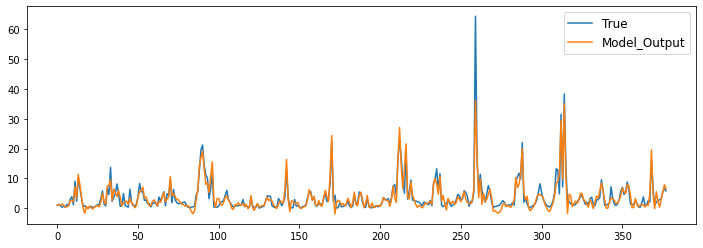

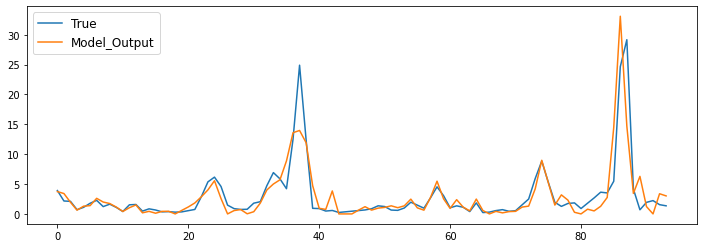

Station Number  30 : 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



KeyboardInterrupt: ignored

In [ ]:
# station_list = ['0', '20', '30', '50', '60', '70', '100', '120', '140', '160']
run_ann('0')

Station Number  0 : 
Index(['chla_for_predict', 'TotalChla_d1', 'TotalChla_d2', 'TotalChla_d3',
       'TotalChla_d4', 'TotalChla_a4', 'TotalChla_d1_last',
       'TotalChla_d2_last', 'TotalChla_d3_last', 'TotalChla_d4_last',
       'TotalChla_a4_last'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/li

hidden_layer:  19
MSE:  1.4615975375970243
RMSE:  1.2089654823844327
MAPE:  182.78332033875623


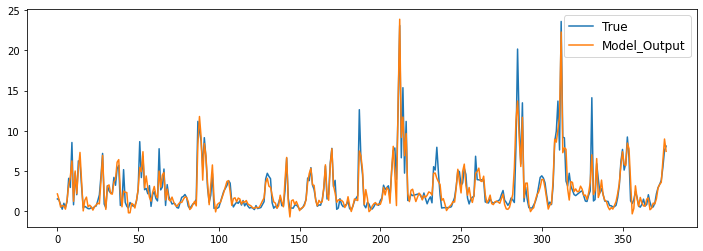

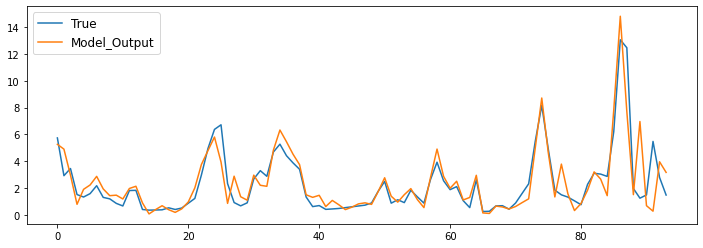

In [ ]:
run_ann_with_only_wavelets('0')

Station Number  20 : 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



hidden_layer:  27
MSE:  6.1945797012712385
RMSE:  2.488891259430841
MAPE:  268.12258212450314
Best length:  18


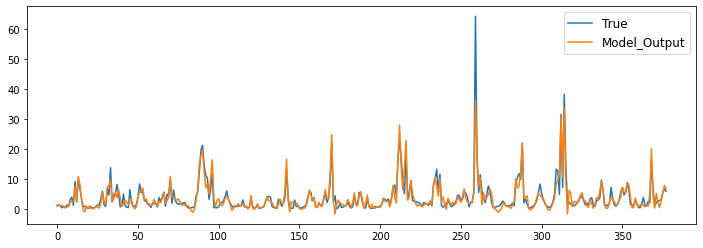

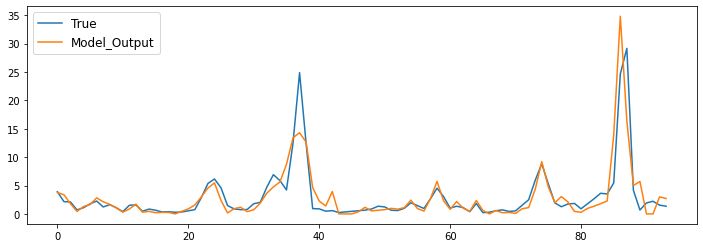

In [ ]:
run_ann('20')

Station Number  20 : 
Index(['chla_for_predict', 'TotalChla_d1', 'TotalChla_d2', 'TotalChla_d3',
       'TotalChla_d4', 'TotalChla_a4', 'TotalChla_d1_last',
       'TotalChla_d2_last', 'TotalChla_d3_last', 'TotalChla_d4_last',
       'TotalChla_a4_last'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/li

hidden_layer:  19
MSE:  7.067542456482292
RMSE:  2.6584849927133862
MAPE:  272.4353483634111


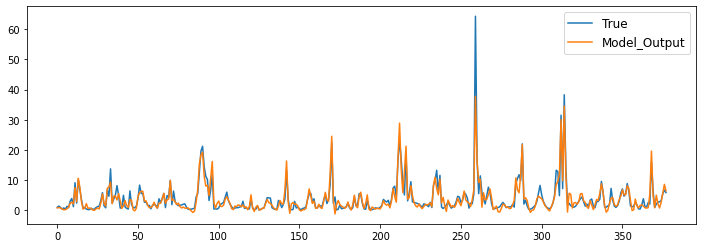

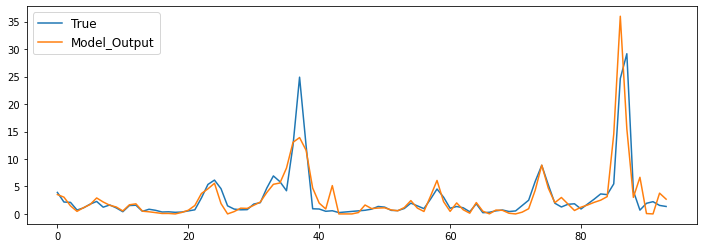

In [ ]:
run_ann_with_only_wavelets('20')

Station Number  30 : 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



hidden_layer:  53
MSE:  25.005662554532073
RMSE:  5.0005662233923145
MAPE:  311.71162757773806
Best length:  30


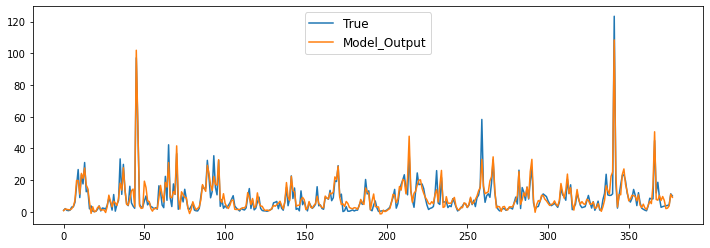

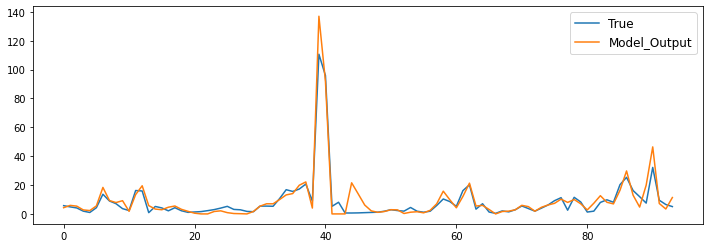

In [ ]:
run_ann('30')

Station Number  30 : 
Index(['chla_for_predict', 'TotalChla_d1', 'TotalChla_d2', 'TotalChla_d3',
       'TotalChla_d4', 'TotalChla_a4', 'TotalChla_d1_last',
       'TotalChla_d2_last', 'TotalChla_d3_last', 'TotalChla_d4_last',
       'TotalChla_a4_last'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/li

hidden_layer:  19
MSE:  24.669243054453876
RMSE:  4.966814175550951
MAPE:  318.8117495741855


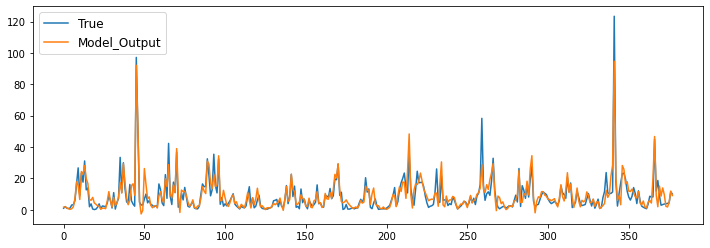

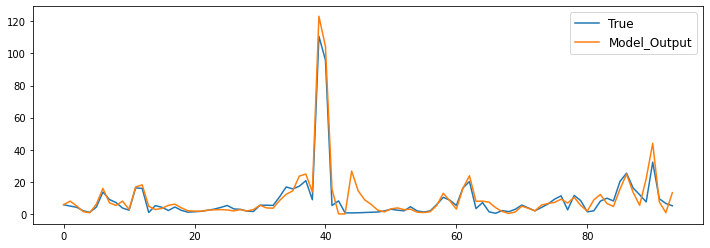

In [ ]:
run_ann_with_only_wavelets('30')

Station Number  50 : 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



hidden_layer:  59
MSE:  34.43258866109927
RMSE:  5.867928822088699
MAPE:  272.0175160077798
Best length:  30


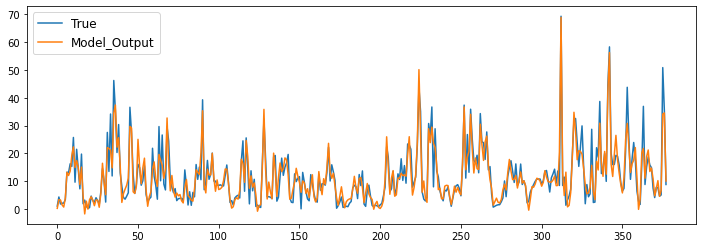

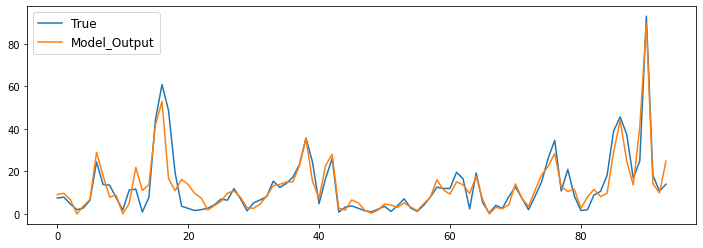

In [ ]:
run_ann('50')

Station Number  50 : 
Index(['chla_for_predict', 'TotalChla_d1', 'TotalChla_d2', 'TotalChla_d3',
       'TotalChla_d4', 'TotalChla_a4', 'TotalChla_d1_last',
       'TotalChla_d2_last', 'TotalChla_d3_last', 'TotalChla_d4_last',
       'TotalChla_a4_last'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/li

hidden_layer:  15
MSE:  40.660464228948726
RMSE:  6.376555828105697
MAPE:  267.05683227997986


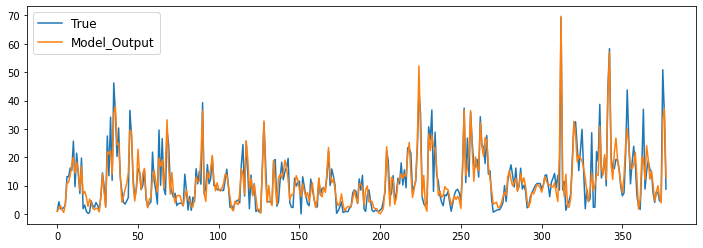

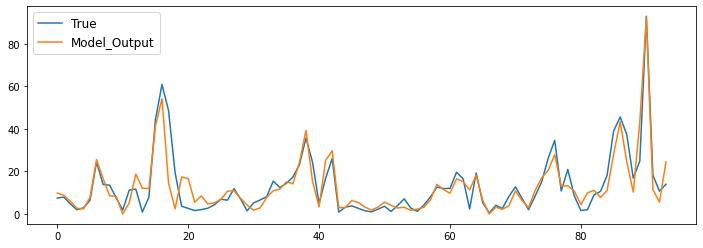

In [ ]:
run_ann_with_only_wavelets('50')

Station Number  60 : 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



hidden_layer:  59
MSE:  16.052194061447704
RMSE:  4.006518945599497
MAPE:  131.79150454890035
Best length:  30


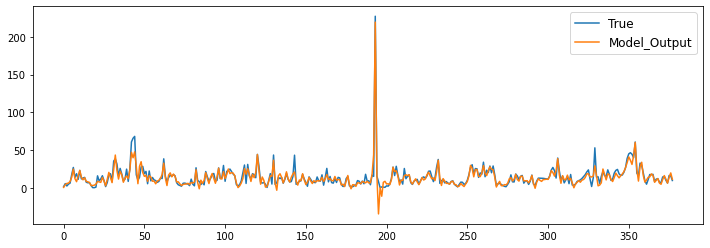

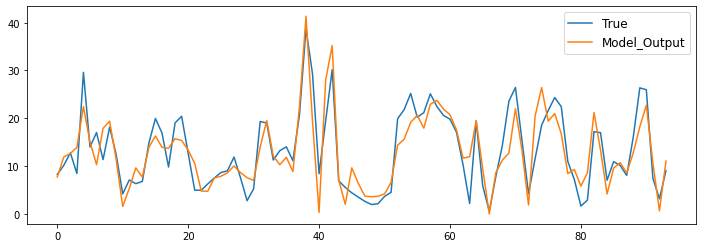

In [ ]:
run_ann('60')

Station Number  60 : 
Index(['chla_for_predict', 'TotalChla_d1', 'TotalChla_d2', 'TotalChla_d3',
       'TotalChla_d4', 'TotalChla_a4', 'TotalChla_d1_last',
       'TotalChla_d2_last', 'TotalChla_d3_last', 'TotalChla_d4_last',
       'TotalChla_a4_last'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/li

hidden_layer:  19
MSE:  20.02822915323965
RMSE:  4.475290957383626
MAPE:  133.6380256776974


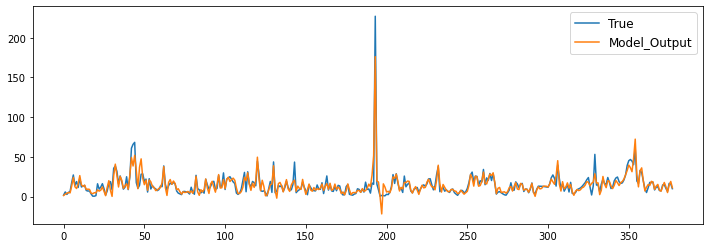

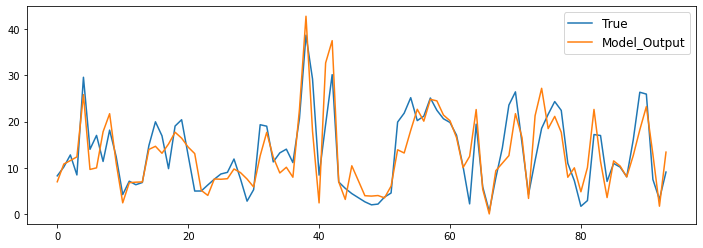

In [ ]:
run_ann_with_only_wavelets('60')

Station Number  70 : 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


hidden_layer:  37
MSE:  16.37097962440002
RMSE:  4.04610672429683
MAPE:  108.66096963093759
Best length:  27


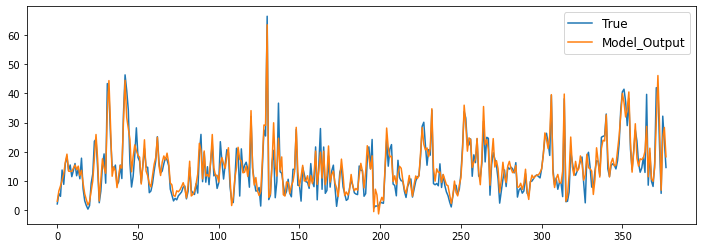

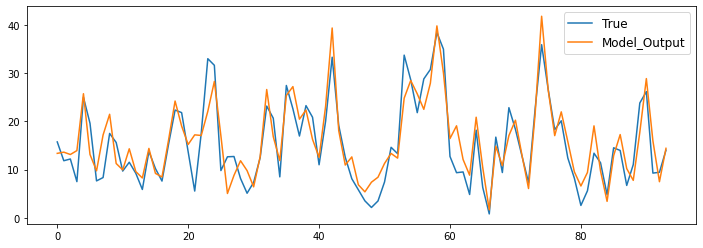

In [ ]:
run_ann('70')

Station Number  70 : 
Index(['chla_for_predict', 'TotalChla_d1', 'TotalChla_d2', 'TotalChla_d3',
       'TotalChla_d4', 'TotalChla_a4', 'TotalChla_d1_last',
       'TotalChla_d2_last', 'TotalChla_d3_last', 'TotalChla_d4_last',
       'TotalChla_a4_last'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/li

hidden_layer:  17
MSE:  16.87394331317842
RMSE:  4.107790563451163
MAPE:  105.53511794219474


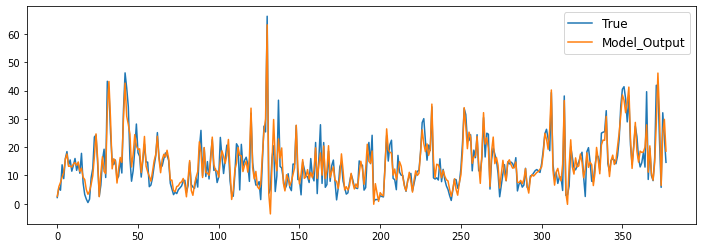

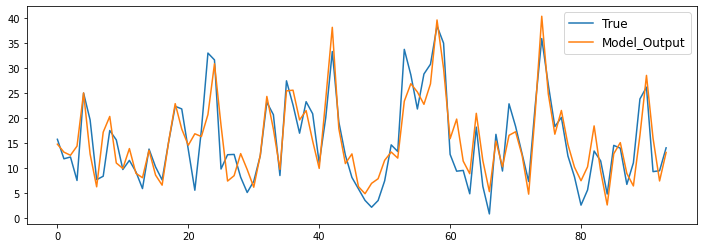

In [ ]:
run_ann_with_only_wavelets('70')

Station Number  100 : 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



hidden_layer:  51
MSE:  27.757837936145926
RMSE:  5.268570767878697
MAPE:  87.38678193706544
Best length:  27


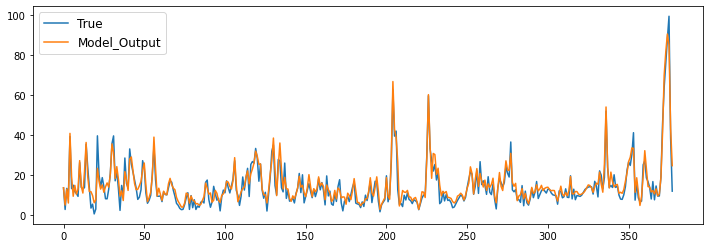

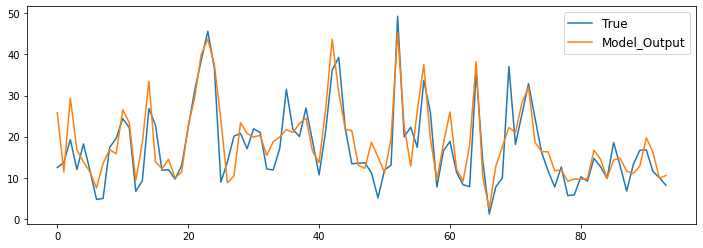

In [ ]:
run_ann('100')

Station Number  100 : 
Index(['chla_for_predict', 'TotalChla_d1', 'TotalChla_d2', 'TotalChla_d3',
       'TotalChla_d4', 'TotalChla_a4', 'TotalChla_d1_last',
       'TotalChla_d2_last', 'TotalChla_d3_last', 'TotalChla_d4_last',
       'TotalChla_a4_last'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/li

hidden_layer:  15
MSE:  32.36704163993941
RMSE:  5.689203954855143
MAPE:  87.35588096528964


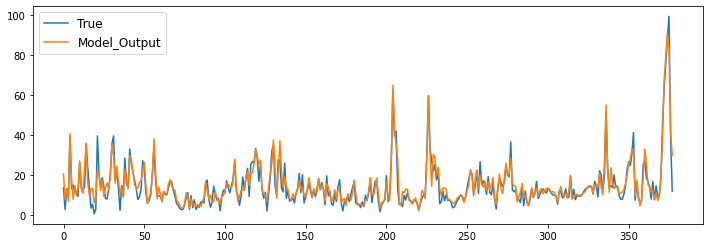

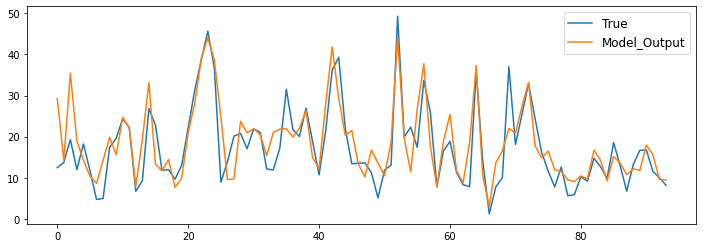

In [ ]:
run_ann_with_only_wavelets('100')

Station Number  120 : 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



hidden_layer:  29
MSE:  71.37044958876817
RMSE:  8.448103313097453
MAPE:  111.66210485842282
Best length:  18


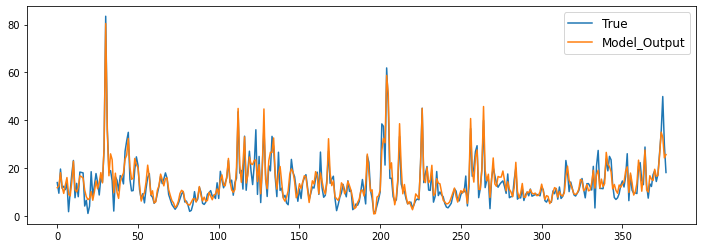

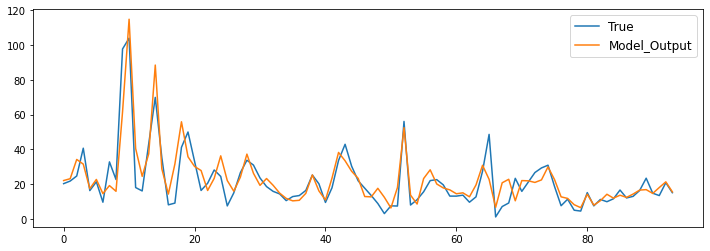

In [ ]:
run_ann('120')

Station Number  120 : 
Index(['chla_for_predict', 'TotalChla_d1', 'TotalChla_d2', 'TotalChla_d3',
       'TotalChla_d4', 'TotalChla_a4', 'TotalChla_d1_last',
       'TotalChla_d2_last', 'TotalChla_d3_last', 'TotalChla_d4_last',
       'TotalChla_a4_last'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/li

hidden_layer:  19
MSE:  72.48781354998297
RMSE:  8.513977539903602
MAPE:  113.1839332444917


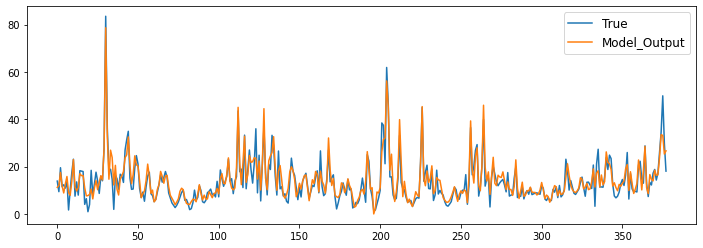

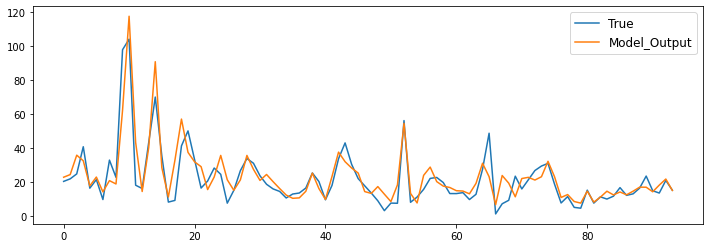

In [ ]:
run_ann_with_only_wavelets('120')

Station Number  140 : 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



hidden_layer:  35
MSE:  61.167367314310944
RMSE:  7.820956930856412
MAPE:  86.4318020558242
Best length:  27


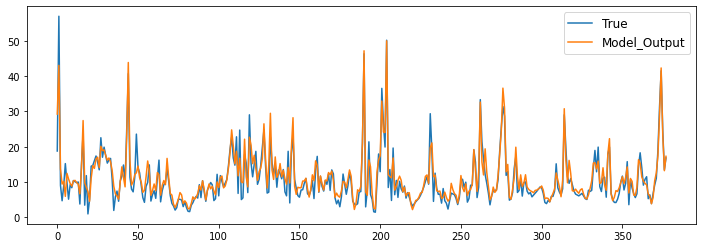

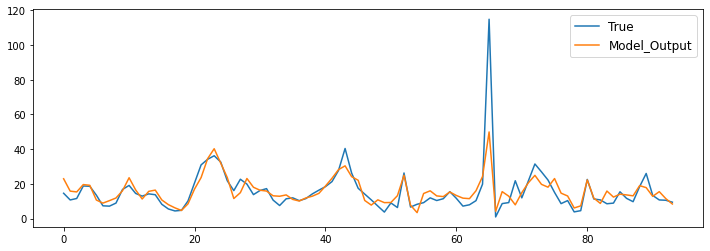

In [ ]:
run_ann('140')

Station Number  140 : 
Index(['chla_for_predict', 'TotalChla_d1', 'TotalChla_d2', 'TotalChla_d3',
       'TotalChla_d4', 'TotalChla_a4', 'TotalChla_d1_last',
       'TotalChla_d2_last', 'TotalChla_d3_last', 'TotalChla_d4_last',
       'TotalChla_a4_last'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/li

hidden_layer:  19
MSE:  70.85066622483242
RMSE:  8.417283779511799
MAPE:  86.59720111561764


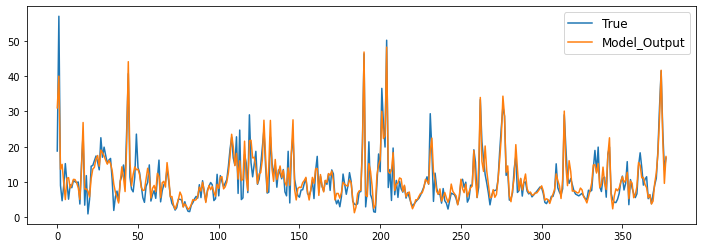

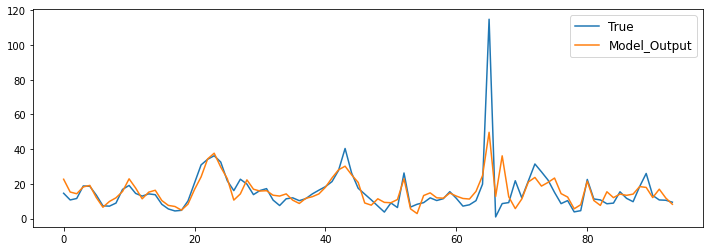

In [ ]:
run_ann_with_only_wavelets('140')

Station Number  160 : 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



hidden_layer:  59
MSE:  15.263345116305487
RMSE:  3.9068331313617026
MAPE:  77.15645959969989
Best length:  30


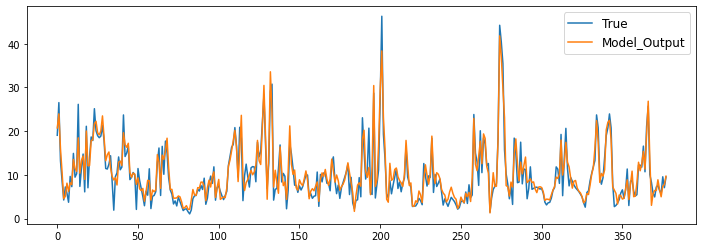

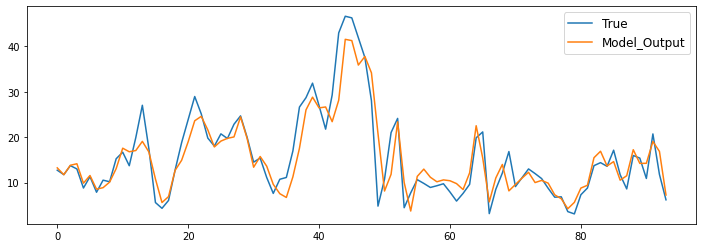

In [ ]:
run_ann('160')

Station Number  160 : 
Index(['chla_for_predict', 'TotalChla_d1', 'TotalChla_d2', 'TotalChla_d3',
       'TotalChla_d4', 'TotalChla_a4', 'TotalChla_d1_last',
       'TotalChla_d2_last', 'TotalChla_d3_last', 'TotalChla_d4_last',
       'TotalChla_a4_last'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/li

hidden_layer:  13
MSE:  14.76391631756154
RMSE:  3.842384197026833
MAPE:  78.49428781673748


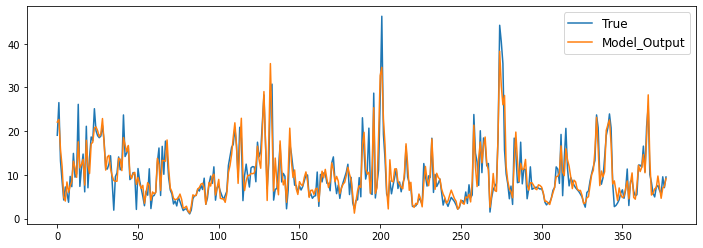

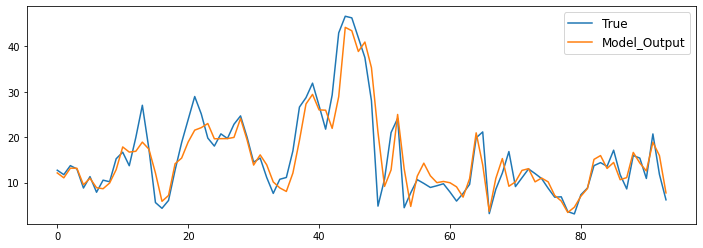

In [ ]:
run_ann_with_only_wavelets('160')

## LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()

In [ ]:
# LSTM
# https://www.cnblogs.com/wushaogui/p/9176617.html 
# https://machinelearningmastery.com/make-predictions-long-short-term-memory-models-keras/
# https://machinelearningmastery.com/tune-lstm-hyperparameters-keras-time-series-forecasting/
def predict_using_LSTM(x_train, y_train, x_test, neurons, n_epochs = 500):
  # transform to the type of data input asked by LSTM
  x_train_input = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
  x_test_input = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
  y_train = y_train.reshape(-1,1)

  # build the LSTM model
  model = Sequential()
  model.add(LSTM(neurons, input_shape=(x_train_input.shape[1], x_train_input.shape[2])))
  model.add(Dense(1, activation='relu'))
  model.compile(optimizer='adam', loss='mse')

  # training
  early_stopping = EarlyStopping()
  custom_early_stopping = EarlyStopping(
    monitor='loss', 
    patience=2, 
    min_delta=0.01, 
    mode='auto'
  )
  model.fit(x_train_input, y_train, epochs=n_epochs, verbose=0, callbacks=[custom_early_stopping])

  # loss estimation
  train_predict = model.predict(x_train_input, verbose=0)
  train_rmse = sqrt(mean_squared_error(y_train, train_predict))

  # predict
  test_predict = model.predict(x_test_input, verbose=0)

  return train_rmse, train_predict, test_predict

In [ ]:
def pipeline_lstm_Jiting(df_data):
  # split the training set and testing set
  x_train, y_train, x_test, y_test = split_data(df_data)

  # the number of hidden layer
  input_layer_num = x_train.shape[1]

  best_res_neurons = 0
  loss_min = float('inf')
  
  for neurons in range(input_layer_num//2, input_layer_num*2, 2):
      train_rmse, y_train_predict, y_test_predict = predict_using_LSTM(x_train, y_train, x_test, neurons)
      if loss_min > train_rmse:
        # print(train_rmse)
        best_res_neurons = neurons
        y_test_res = y_test_predict
        y_train_res = y_train_predict

  return best_res_neurons, y_train, y_train_res, y_test, y_test_res

In [ ]:
def run_lstm(station_num):
  print("Station Number ", station_num, ": ")
  df_junan_modmon_data = pd.read_csv('./Junan Modmon Data/new_interpolated_Station_' + station_num + '_Depth_1_.csv')

  # process time
  df_junan_modmon_data['Date'] = [datetime.strptime(date, '%Y-%m-%d').date() for date in df_junan_modmon_data['Date'].astype(str).values.tolist()]

  # keep testing set
  df_save_for_plot = df_junan_modmon_data[df_junan_modmon_data['Date'] >= datetime.strptime("2014-3-25", '%Y-%m-%d').date()]
  df_save_for_plot = df_save_for_plot[['Date', 'TotalChla']]
  df_save_for_plot = df_save_for_plot.rename(columns={"TotalChla": "Groud_Truth"})
  df_save_for_plot = df_save_for_plot.reset_index(drop=True)

  # keep these columns
  order = ['YSI_Temp', 'YSI_Salinity', 'YSI_DO', 'YSI_pH', 'POC', 'NOx', "NH4", 'PO4', 'TotalChla', 'ACC_WSPD_2',	'ACC_PRES_3',	'ACC_ATMP_5', 'ACC_FLOW_5']
  df_modmon = df_junan_modmon_data[order]


  kwargs_modmon_all_feature = {
    "wav_dict": [ {'wav_col': 'TotalChla', 'wavelet_type': 'db4', 'level_num': 4} ],
    "cols_to_keep": ['YSI_Temp', 'YSI_Salinity', 'YSI_DO', 'YSI_pH', 'POC', 'NOx', "NH4", 'PO4', 'TotalChla', 'ACC_WSPD_2',	'ACC_PRES_3',	'ACC_ATMP_5', 'ACC_FLOW_5'],
    # acc_flow vec_acc_windspedd vec_acc_wind_direction acc_temperature acc_
    # pressure?
    # "one_hot_encoding_cols": ['Season'],
    "shift_params": {'known_month': 1, 'predict_col_name': 'TotalChla', 'features_use_current_observation': ['ACC_WSPD_2',	'ACC_PRES_3',	'ACC_ATMP_5', 'ACC_FLOW_5']}
    # known_month parameter is 1 for 2 months, 0 for the past month
  }

  df_modmon_junan = data_prep_Jiting(df_modmon, **kwargs_modmon_all_feature)

  # feature importance
  df_import = get_feature_importance(df_modmon_junan)
  print(df_import)
  columns = df_import.index.to_list()

  curr_mse = sys.maxsize

  length = len(columns)
  for vec_len in range((int)(0.5*length), length+1, 3):
    cols = columns[:vec_len] + ["chla_for_predict"]
    df_data = df_modmon_junan[cols] 

    neurons, y_train, y_train_res, y_test, y_test_res = pipeline_lstm_Jiting(df_data)
    err_mse = mean_squared_error(y_test, y_test_res)

    if err_mse < curr_mse:
      curr_mse = err_mse
      save_neurons, save_y_train, save_y_train_res, save_y_test, save_y_test_res = neurons, y_train, y_train_res, y_test, y_test_res
      best_length = vec_len

  # output result
  print("hidden_layer: ", save_neurons)
  print_error(save_y_test, save_y_test_res)
  print("Best length: ", best_length)

  df_test_result = pd.DataFrame(y_test_res, columns=['Prediction'])
  df_test_result = df_test_result.reset_index(drop=True)
  
  plot_line_chart_for_train_or_test_set(save_y_train, save_y_train_res)
  
  plot_line_chart_for_train_or_test_set(save_y_test, save_y_test_res)

  df_save_csv = pd.concat([df_save_for_plot, df_test_result], axis=1)
  df_save_csv.to_csv('./Result/LSTM/Station_' + station_num + '_Depth_1_.csv')


In [ ]:
kwargs_modmon_without_wavelet = {
  "cols_to_keep": ['YSI_Temp', 'YSI_Salinity', 'YSI_DO', 'YSI_pH', 'POC', 'NOx', "NH4", 'PO4', 'TotalChla', 'ACC_WSPD_2',	'ACC_PRES_3',	'ACC_ATMP_5', 'ACC_FLOW_5'], 
  # acc_flow vec_acc_windspedd vec_acc_wind_direction acc_temperature acc_
  # pressure?
  # "one_hot_encoding_cols": ['Season'],
  "shift_params": {'known_month': 1, 'predict_col_name': 'TotalChla', 'features_use_current_observation': ['ACC_WSPD_2',	'ACC_PRES_3',	'ACC_ATMP_5', 'ACC_FLOW_5']}
  # known_month parameter is 1 for 2 months, 0 for the past month
}

kwargs_modmon_only_wavelet = {
  "wav_dict": [ {'wav_col': 'TotalChla', 'wavelet_type': 'db4', 'level_num': 4} ],
  "cols_to_keep": ['TotalChla'],
  # acc_flow vec_acc_windspedd vec_acc_wind_direction acc_temperature acc_
  # pressure?
  # "one_hot_encoding_cols": ['Season'],
  "shift_params": {'known_month': 1, 'predict_col_name': 'TotalChla', 'features_use_current_observation': []}
  # known_month parameter is 1 for 2 months, 0 for the past month
} 

# this for no wind features
kwargs_modmon_without_wind = {
  "wav_dict": [ {'wav_col': 'TotalChla', 'wavelet_type': 'db4', 'level_num': 4} ],
  "cols_to_keep": ['YSI_Temp', 'YSI_Salinity', 'YSI_DO', 'YSI_pH', 'POC', 'NOx', "NH4", 'PO4', 'TotalChla', 'ACC_FLOW_5'], 
  # acc_flow vec_acc_windspedd vec_acc_wind_direction acc_temperature acc_
  # pressure?
  # "one_hot_encoding_cols": ['Season'],
  "shift_params": {'known_month': 1, 'predict_col_name': 'TotalChla', 'features_use_current_observation': ['ACC_FLOW_5']}
}

kwargs_modmon_all_feature = {
  "wav_dict": [ {'wav_col': 'TotalChla', 'wavelet_type': 'db4', 'level_num': 4} ],

  "cols_to_keep": ['YSI_Temp', 'YSI_Salinity', 'YSI_DO', 'YSI_pH', 'POC', 'NOx', "NH4", 'PO4', 'TotalChla', 'ACC_WSPD_2',	'ACC_PRES_3',	'ACC_ATMP_5', 'ACC_FLOW_5'],
  # acc_flow vec_acc_windspedd vec_acc_wind_direction acc_temperature acc_
  # pressure?
  # "one_hot_encoding_cols": ['Season'],
  "shift_params": {'known_month': 1, 'predict_col_name': 'TotalChla', 'features_use_current_observation': ['ACC_WSPD_2',	'ACC_PRES_3',	'ACC_ATMP_5', 'ACC_FLOW_5']}
}



Station Number  0 : 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



                   importance
TotalChla_d1         0.176508
TotalChla_d4         0.159973
TotalChla_d3         0.122225
TotalChla_d4_last    0.069137
ACC_FLOW_5           0.061300
TotalChla_d2_last    0.054818
YSI_Temp             0.036834
TotalChla_a4         0.035456
YSI_pH               0.022963
POC                  0.022664
TotalChla_a4_last    0.022363
NH4                  0.018064
ACC_PRES_3           0.017497
YSI_DO_last          0.015756
YSI_DO               0.014864
TotalChla_d2         0.013911
TotalChla_d1_last    0.013213
PO4                  0.013191
NH4_last             0.011964
ACC_ATMP_5           0.011265
POC_last             0.009852
PO4_last             0.009816
YSI_pH_last          0.009631
ACC_WSPD_2           0.008906
YSI_Salinity_last    0.008874
NOx                  0.008830
YSI_Salinity         0.008044
YSI_Temp_last        0.007828
TotalChla_d3_last    0.007686
NOx_last             0.006569
hidden_layer:  59
MSE:  1.6020857
RMSE:  1.2657353
MAPE:  45.239439606

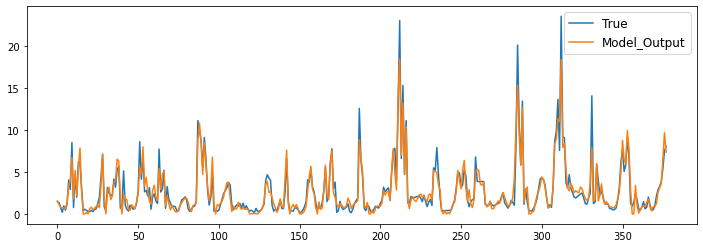

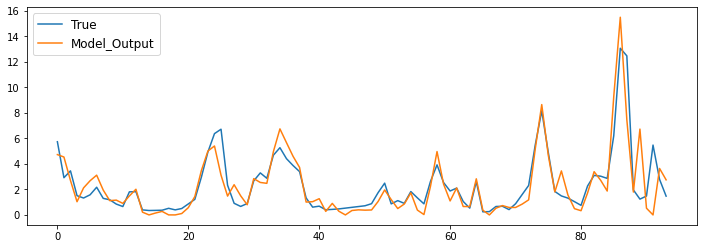

In [ ]:
run_lstm('0')

Station Number  20 : 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



                   importance
TotalChla_d1         0.327450
ACC_FLOW_5           0.100941
TotalChla_d3         0.100372
TotalChla_d4         0.056494
YSI_Temp             0.055736
TotalChla_d2_last    0.039838
YSI_pH_last          0.032204
POC                  0.024405
YSI_pH               0.023570
ACC_ATMP_5           0.021044
TotalChla_a4         0.019268
TotalChla_a4_last    0.016504
TotalChla_d3_last    0.016065
TotalChla_d1_last    0.015804
ACC_PRES_3           0.015447
NOx                  0.013656
TotalChla_d4_last    0.011439
NH4_last             0.011389
POC_last             0.010599
NH4                  0.010575
YSI_DO               0.010556
NOx_last             0.010465
YSI_Salinity         0.008869
PO4_last             0.008381
YSI_DO_last          0.007425
YSI_Salinity_last    0.007412
TotalChla_d2         0.006772
YSI_Temp_last        0.006381
ACC_WSPD_2           0.005944
PO4                  0.004996
hidden_layer:  53
MSE:  6.5152392
RMSE:  2.5524967
MAPE:  72.568190097

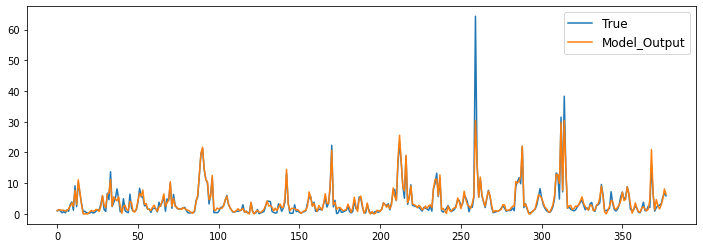

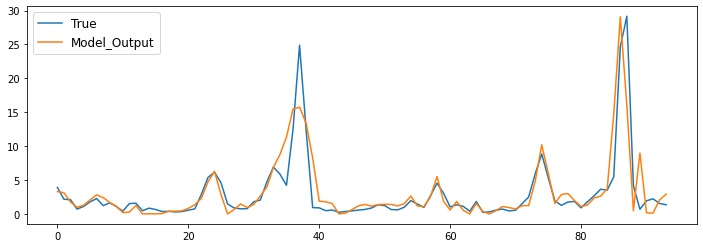

In [ ]:
run_lstm('20')

Station Number  30 : 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



                   importance
TotalChla_d2_last    0.512200
ACC_FLOW_5           0.136921
TotalChla_d1         0.042373
ACC_ATMP_5           0.038960
TotalChla_a4         0.023531
YSI_Temp             0.023304
TotalChla_d2         0.017248
ACC_PRES_3           0.016183
TotalChla_d3         0.014665
TotalChla_d3_last    0.014311
ACC_WSPD_2           0.013620
TotalChla_d4         0.012360
NOx_last             0.011041
TotalChla_a4_last    0.010488
YSI_Salinity         0.009621
TotalChla_d1_last    0.009146
POC                  0.009013
NOx                  0.008783
PO4                  0.008773
YSI_DO_last          0.008280
NH4                  0.007103
POC_last             0.006788
YSI_Temp_last        0.006460
YSI_Salinity_last    0.006238
NH4_last             0.005934
YSI_DO               0.005696
TotalChla_d4_last    0.005691
PO4_last             0.005657
YSI_pH_last          0.005087
YSI_pH               0.004527
hidden_layer:  53
MSE:  54.760387
RMSE:  7.4000263
MAPE:  101.70665979

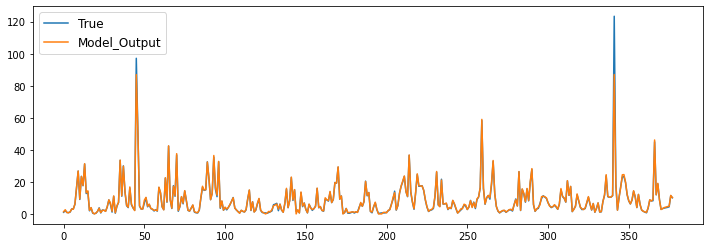

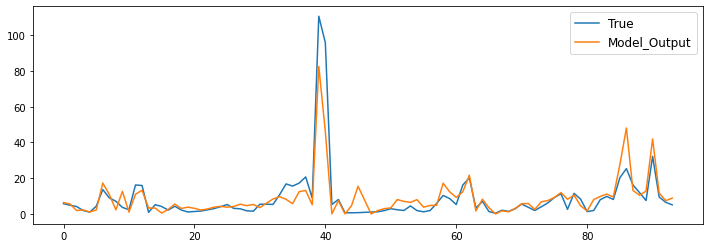

In [ ]:
run_lstm('30')

Station Number  50 : 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



                   importance
TotalChla_d1         0.279564
TotalChla_d2_last    0.127073
TotalChla_d2         0.094858
ACC_FLOW_5           0.075252
TotalChla_d3         0.062949
POC                  0.052693
TotalChla_a4         0.030908
TotalChla_d4         0.029656
ACC_ATMP_5           0.017824
TotalChla_a4_last    0.017220
TotalChla_d1_last    0.016219
TotalChla_d3_last    0.015024
YSI_DO_last          0.014175
YSI_pH_last          0.012072
YSI_pH               0.011764
NOx_last             0.011284
NOx                  0.011114
YSI_Temp             0.011102
POC_last             0.011031
NH4_last             0.010842
ACC_PRES_3           0.010336
YSI_Salinity_last    0.009881
NH4                  0.009706
YSI_Temp_last        0.009380
PO4                  0.009013
TotalChla_d4_last    0.008548
ACC_WSPD_2           0.008467
YSI_DO               0.007898
YSI_Salinity         0.007720
PO4_last             0.006429
hidden_layer:  59
MSE:  63.335087
RMSE:  7.9583344
MAPE:  66.506808996

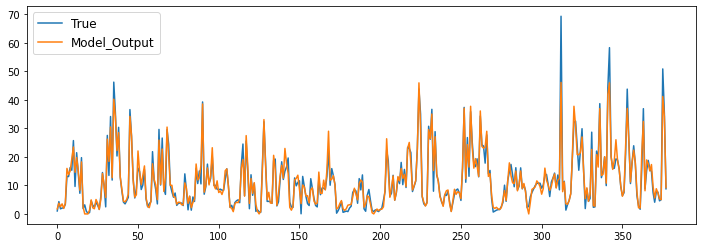

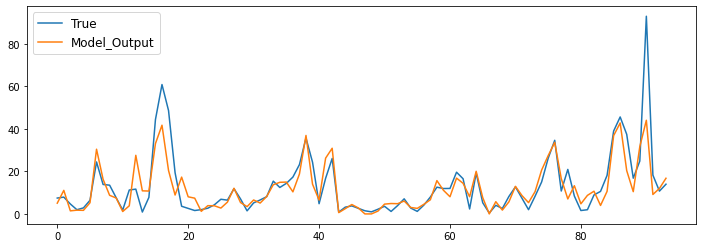

In [ ]:
run_lstm('50')

Station Number  60 : 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



                   importance
TotalChla_a4_last    0.123638
TotalChla_d4         0.111532
TotalChla_d1         0.105230
TotalChla_d3         0.087207
TotalChla_d2_last    0.068602
TotalChla_a4         0.056798
TotalChla_d4_last    0.055292
ACC_FLOW_5           0.049647
TotalChla_d2         0.040280
NH4_last             0.034679
POC                  0.027134
TotalChla_d1_last    0.023213
POC_last             0.020818
PO4                  0.019354
TotalChla_d3_last    0.015988
ACC_ATMP_5           0.014723
NH4                  0.014238
YSI_Salinity_last    0.013699
YSI_Temp_last        0.012488
ACC_WSPD_2           0.011337
NOx_last             0.010965
YSI_Temp             0.010754
YSI_DO_last          0.010305
NOx                  0.009883
ACC_PRES_3           0.009487
PO4_last             0.009381
YSI_pH_last          0.009261
YSI_DO               0.008193
YSI_Salinity         0.008048
YSI_pH               0.007823
hidden_layer:  29
MSE:  13.514529
RMSE:  3.6762114
MAPE:  42.838230729

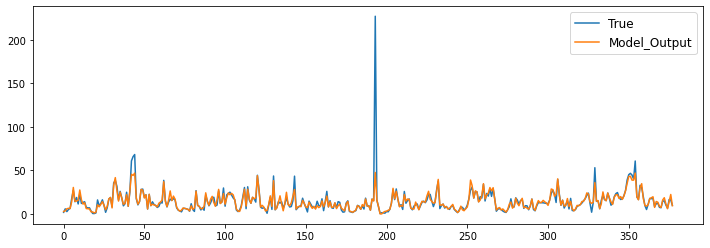

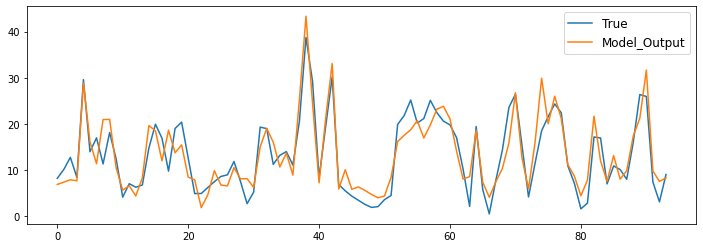

In [ ]:
run_lstm('60')

Station Number  70 : 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



                   importance
TotalChla_d3         0.218187
TotalChla_d1         0.154886
TotalChla_d4         0.078290
TotalChla_d2         0.066009
TotalChla_a4         0.058769
TotalChla_d2_last    0.050239
ACC_FLOW_5           0.039608
POC                  0.034825
TotalChla_a4_last    0.031161
TotalChla_d4_last    0.017922
NOx_last             0.017669
YSI_Salinity_last    0.016659
YSI_pH_last          0.015793
ACC_PRES_3           0.015422
TotalChla_d1_last    0.014971
NH4_last             0.014865
PO4                  0.014760
POC_last             0.014237
TotalChla_d3_last    0.014089
YSI_DO               0.013668
YSI_Temp             0.013269
ACC_WSPD_2           0.011576
YSI_pH               0.011455
PO4_last             0.011347
NH4                  0.010444
NOx                  0.008862
ACC_ATMP_5           0.008368
YSI_DO_last          0.008262
YSI_Salinity         0.007561
YSI_Temp_last        0.006825
hidden_layer:  53
MSE:  15.645228
RMSE:  3.955405
MAPE:  26.2146651744

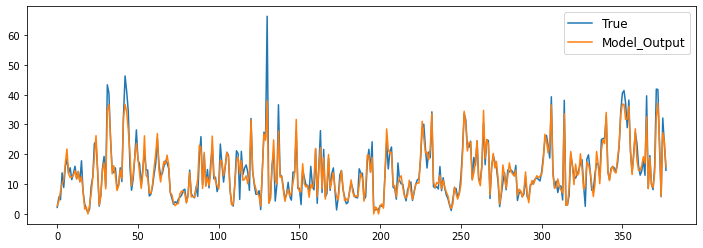

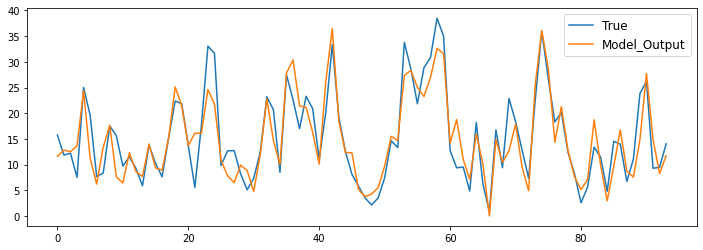

In [ ]:
run_lstm('70')

Station Number  100 : 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



                   importance
TotalChla_d4         0.257253
TotalChla_d3         0.122838
TotalChla_d2_last    0.093617
TotalChla_d1         0.069182
TotalChla_a4_last    0.056955
TotalChla_d4_last    0.054593
TotalChla_d2         0.037740
TotalChla_a4         0.036700
POC                  0.028534
ACC_FLOW_5           0.027308
TotalChla_d1_last    0.017791
NOx                  0.016640
ACC_ATMP_5           0.014667
TotalChla_d3_last    0.014153
YSI_pH               0.012180
PO4                  0.011945
NH4                  0.011792
ACC_PRES_3           0.011181
POC_last             0.011001
ACC_WSPD_2           0.010228
PO4_last             0.010001
NOx_last             0.009382
YSI_pH_last          0.009100
YSI_DO_last          0.008922
YSI_DO               0.008731
YSI_Temp_last        0.008344
YSI_Temp             0.008166
YSI_Salinity         0.007625
NH4_last             0.006815
YSI_Salinity_last    0.006616
hidden_layer:  35
MSE:  23.601976
RMSE:  4.8581867
MAPE:  27.291205525

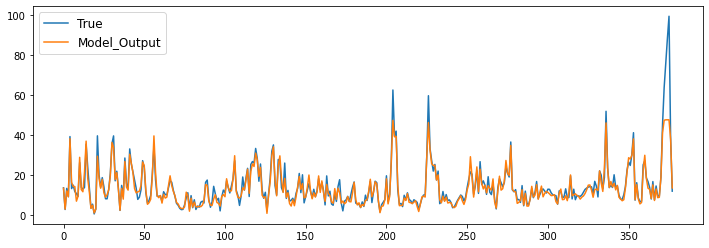

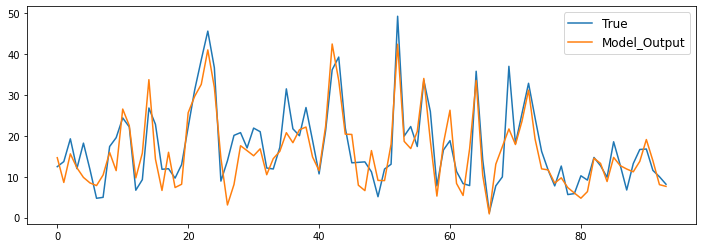

In [ ]:
run_lstm('100')

Station Number  120 : 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



                   importance
TotalChla_d1         0.222017
TotalChla_d2         0.160210
TotalChla_a4         0.091515
TotalChla_d2_last    0.084899
TotalChla_a4_last    0.078830
TotalChla_d3         0.046176
TotalChla_d4         0.037560
TotalChla_d1_last    0.027483
NOx_last             0.017581
YSI_Temp_last        0.017199
TotalChla_d4_last    0.015504
ACC_PRES_3           0.015258
ACC_FLOW_5           0.014623
POC                  0.014148
ACC_ATMP_5           0.013591
NH4_last             0.012901
PO4                  0.012159
POC_last             0.011997
TotalChla_d3_last    0.011744
NH4                  0.011288
YSI_DO               0.010513
YSI_pH               0.010043
NOx                  0.009982
PO4_last             0.009345
YSI_Salinity         0.009005
ACC_WSPD_2           0.008540
YSI_Salinity_last    0.007450
YSI_pH_last          0.007001
YSI_DO_last          0.005992
YSI_Temp             0.005447
hidden_layer:  59
MSE:  145.11295
RMSE:  12.046284
MAPE:  36.004549264

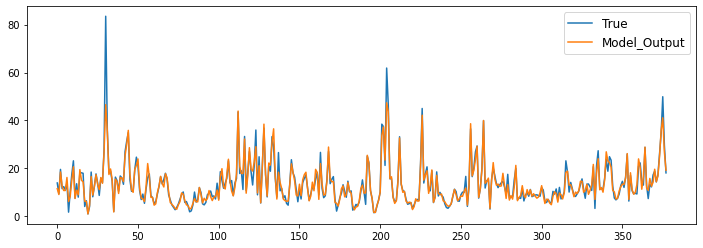

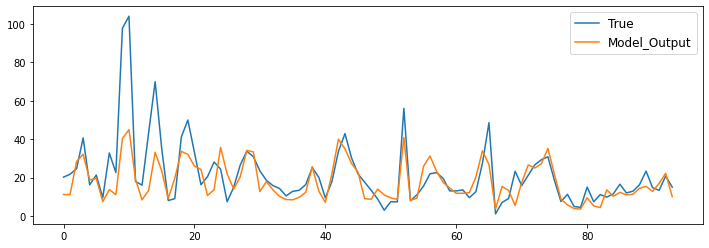

In [ ]:
run_lstm('120')

Station Number  140 : 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



                   importance
TotalChla_d1         0.308115
TotalChla_d4         0.096248
TotalChla_a4_last    0.056423
TotalChla_d3         0.047891
TotalChla_a4         0.044177
ACC_FLOW_5           0.041176
POC                  0.034522
NH4                  0.031452
TotalChla_d2_last    0.029919
TotalChla_d4_last    0.024241
ACC_PRES_3           0.023665
TotalChla_d1_last    0.023291
YSI_Temp             0.020174
TotalChla_d2         0.020003
PO4                  0.018922
NH4_last             0.017735
TotalChla_d3_last    0.015561
ACC_WSPD_2           0.015195
NOx                  0.014152
YSI_Temp_last        0.013693
YSI_Salinity_last    0.013294
POC_last             0.012660
YSI_Salinity         0.011945
YSI_pH               0.010503
ACC_ATMP_5           0.010274
YSI_DO_last          0.010134
YSI_DO               0.009517
NOx_last             0.008935
PO4_last             0.008912
YSI_pH_last          0.007270
hidden_layer:  40
MSE:  90.52206
RMSE:  9.514308
MAPE:  29.18190062046

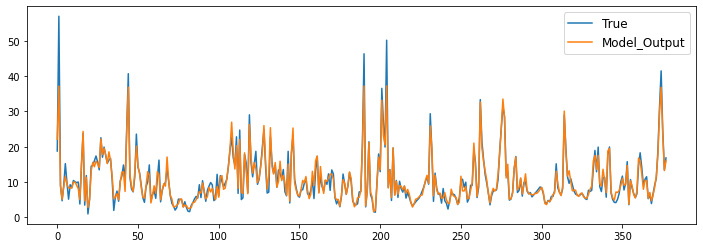

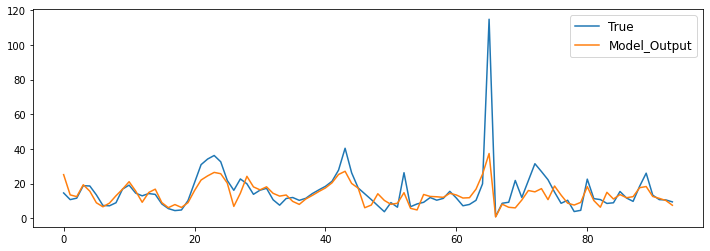

In [ ]:
run_lstm('140')

Station Number  160 : 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



                   importance
TotalChla_a4         0.288724
POC                  0.099316
TotalChla_a4_last    0.067167
TotalChla_d1         0.059396
TotalChla_d1_last    0.056730
TotalChla_d2_last    0.047938
TotalChla_d4         0.043333
TotalChla_d3         0.038342
TotalChla_d4_last    0.027694
TotalChla_d2         0.027540
NOx_last             0.025296
ACC_FLOW_5           0.022177
ACC_PRES_3           0.016210
YSI_Temp_last        0.013719
TotalChla_d3_last    0.013176
PO4_last             0.013056
ACC_ATMP_5           0.012872
YSI_Salinity         0.012818
YSI_pH_last          0.012694
YSI_pH               0.011118
NOx                  0.010406
YSI_Salinity_last    0.010288
YSI_Temp             0.009934
POC_last             0.009900
PO4                  0.008719
NH4                  0.008652
ACC_WSPD_2           0.008601
YSI_DO_last          0.008289
YSI_DO               0.008035
NH4_last             0.007859
hidden_layer:  59
MSE:  42.019657
RMSE:  6.482257
MAPE:  24.2504850029

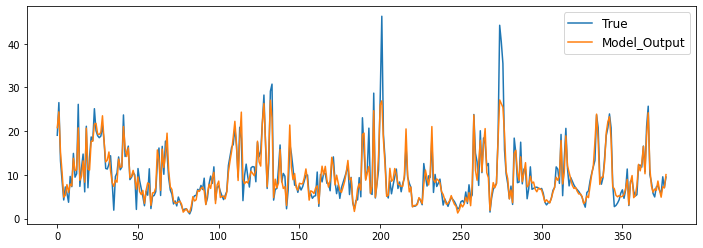

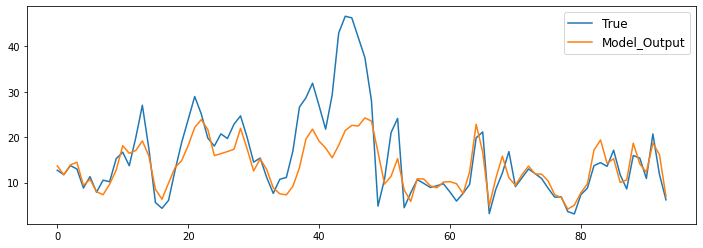

In [ ]:
run_lstm('160')

In [ ]:
# station_list = ['0', '20', '30', '50', '60', '70', '100', '120', '140', '160']
# # station_list = ['20']
# for station in station_list:
#   run_lstm(station)
#   print("\n\n")

# kwargs_modmon_without_wavelet
# kwargs_modmon_only_wavelet
# kwargs_modmon_without_wind
# kwargs_modmon_all_feature

In [ ]:
# # patience = 8
# station_list = ['0', '20', '30', '50', '60', '70', '100', '120', '140', '160']
# # station_list = ['20']
# for station in station_list:
#   run_lstm(station)
#   print("\n\n")

# kwargs_modmon_without_wavelet
# kwargs_modmon_only_wavelet
# kwargs_modmon_without_wind
# kwargs_modmon_all_feature


## Scripps Pier

In [ ]:
df_scripps = pd.read_csv('scripps_pier_data.csv')
df_scripps['Date'] = [datetime.strptime(date, '%Y-%m-%d').date() for date in df_scripps['date'].astype(str).values.tolist()]

# keep testing set
df_save_for_plot = df_scripps[df_scripps['Date'] >= datetime.strptime("2014-1-20", '%Y-%m-%d').date()]
df_save_for_plot = df_save_for_plot[['Date', 'Chlorophyll (mg/m3)']]
df_save_for_plot = df_save_for_plot.rename(columns={"Chlorophyll (mg/m3)": "Groud_Truth"})
df_save_for_plot = df_save_for_plot.reset_index(drop=True)

column_list = ['Chlorophyll (mg/m3)', 'Nitrate (uM)', 'Nitrite (uM)', 'Phosphate (uM)', 'Silicate (uM)', 'Water Temperature', 'WDIR', 'WSPD']
df_scripps = df_scripps[column_list]

# column_list_without_wind = ['Chlorophyll (mg/m3)', 'Nitrate (uM)', 'Nitrite (uM)', 'Phosphate (uM)', 'Silicate (uM)', 'Water Temperature']
# df_scripps = df_scripps[column_list_without_wind]
df_scripps

,Chlorophyll (mg/m3),Nitrate (uM),Nitrite (uM),Phosphate (uM),Silicate (uM),Water Temperature,WDIR,WSPD
0,1.82,0.43,0.03,0.24,5.64,19.8,310.705633,3.575371
1,2.71,0.83,0.04,0.37,5.10,17.3,180.861405,1.937857
2,1.00,0.14,0.01,0.28,4.10,21.7,275.746780,1.546523
3,1.23,0.17,0.01,0.19,4.70,20.2,197.622091,1.584351
4,2.41,0.21,0.00,0.13,4.70,22.4,188.745235,1.611409
...,...,...,...,...,...,...,...,...
356,1.15,0.59,0.16,0.25,3.16,16.9,321.504845,2.881291
357,1.52,0.35,0.09,0.19,2.85,18.9,302.402199,3.057892
358,1.85,0.22,0.06,0.18,3.44,18.0,316.300910,1.725474
359,2.46,0.16,0.06,0.22,4.60,16.7,285.667458,3.259573


In [ ]:
kwargs_scripps_Jiting = {
  "wav_dict": [ {'wav_col': 'Chlorophyll (mg/m3)', 'wavelet_type': 'db4', 'level_num': 4} ],
  "cols_to_keep": column_list,
  "shift_params": {'known_month': 1, 'predict_col_name': 'Chlorophyll (mg/m3)', 'features_use_current_observation': ['WDIR', 'WSPD']}
}

# kwargs_scripps_Jiting = {
#   "wav_dict": [ {'wav_col': 'Chlorophyll (mg/m3)', 'wavelet_type': 'db4', 'level_num': 4} ],
#   "cols_to_keep": column_list_without_wind, 
#   "shift_params": {'known_month': 1, 'predict_col_name': 'Chlorophyll (mg/m3)', 'features_use_current_observation': []}
# }
# water temperature is not the current observation
df_scripps_all = data_prep_Jiting(df_scripps, **kwargs_scripps_Jiting)

df_scripps_all

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



,chla_for_predict,Nitrate (uM),Nitrite (uM),Phosphate (uM),Silicate (uM),Water Temperature,WDIR,WSPD,Chlorophyll (mg/m3)_d1,Chlorophyll (mg/m3)_d2,...,Nitrate (uM)_last,Nitrite (uM)_last,Phosphate (uM)_last,Silicate (uM)_last,Water Temperature_last,Chlorophyll (mg/m3)_d1_last,Chlorophyll (mg/m3)_d2_last,Chlorophyll (mg/m3)_d3_last,Chlorophyll (mg/m3)_d4_last,Chlorophyll (mg/m3)_a4_last
1,1.00,0.079772,0.129032,0.343434,0.386950,0.372881,0.765829,0.154554,0.883986,0.027808,...,0.041785,0.096774,0.212121,0.427921,0.584746,-0.242797,0.196015,0.041865,-0.037721,1.862638
2,1.23,0.014245,0.032258,0.252525,0.311077,0.745763,0.547789,0.159104,-0.715322,-0.042607,...,0.079772,0.129032,0.343434,0.386950,0.372881,0.883986,0.027808,-0.047619,-0.030765,1.876590
3,2.41,0.017094,0.032258,0.161616,0.356601,0.618644,0.523014,0.162358,-0.433239,-0.093061,...,0.014245,0.032258,0.252525,0.311077,0.745763,-0.715322,-0.042607,-0.110271,-0.024736,1.892935
4,1.90,0.020893,0.000000,0.101010,0.356601,0.805085,0.471188,0.201683,0.696377,-0.027557,...,0.017094,0.032258,0.161616,0.356601,0.618644,-0.433239,-0.093061,-0.135571,-0.019974,1.911845
5,1.80,0.008547,0.000000,0.131313,0.333839,0.855932,0.847341,0.244699,-0.035194,0.206756,...,0.020893,0.000000,0.101010,0.356601,0.805085,0.696377,-0.027557,-0.179933,-0.010722,1.931835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,1.15,0.226971,0.677419,0.333333,0.492413,0.313559,0.893536,0.315088,0.506269,0.059402,...,0.019943,0.096774,0.171717,0.295903,0.381356,-0.273000,-0.022419,0.054299,-0.207308,1.518427
356,1.52,0.056980,0.516129,0.222222,0.239757,0.338983,0.840222,0.336328,-0.443226,-0.018455,...,0.226971,0.677419,0.333333,0.492413,0.313559,0.506269,0.059402,-0.024364,-0.146409,1.655103
357,1.85,0.034188,0.290323,0.161616,0.216237,0.508475,0.879012,0.176077,0.026450,-0.236269,...,0.056980,0.516129,0.222222,0.239757,0.338983,-0.443226,-0.018455,-0.137626,-0.052023,1.801331
358,2.46,0.021842,0.193548,0.151515,0.261002,0.432203,0.793517,0.360584,0.098268,-0.148504,...,0.034188,0.290323,0.161616,0.216237,0.508475,0.026450,-0.236269,-0.299013,0.069979,1.958853


### Scripps ANN Model

hidden_layer:  32
MSE:  0.16614248153256628
RMSE:  0.4076057918290248
MAPE:  65.0690458519734
Best length:  17


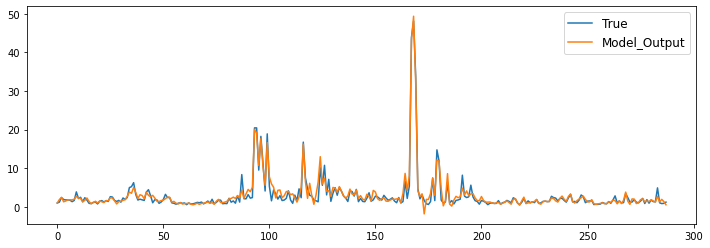

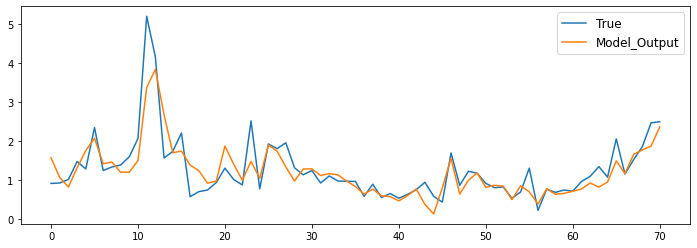

In [ ]:
# feature importance
df_import = get_feature_importance(df_scripps_all)
columns = df_import.index.to_list()

curr_mse = sys.maxsize

length = len(columns)
for vec_len in range((int)(0.5*length), length+3, 3):
  cols = columns[:vec_len] + ["chla_for_predict"]
  df_data = df_scripps_all[cols] 

  hidden_layer, y_train, y_train_res, y_test, y_test_res = pipeline_ann_Jiting(df_data)
  err_mse = mean_squared_error(y_test, y_test_res)

  if err_mse < curr_mse:
    curr_mse = err_mse
    save_hidden_layer, save_y_train, save_y_train_res, save_y_test, save_y_test_res = hidden_layer, y_train, y_train_res, y_test, y_test_res
    best_length = vec_len


# output result
print("hidden_layer: ", save_hidden_layer)
print_error(save_y_test, save_y_test_res)
print("Best length: ", best_length)

# save result
df_test_result = pd.DataFrame(save_y_test_res, columns=['Prediction'])
df_test_result = df_test_result.reset_index(drop=True)

plot_line_chart_for_train_or_test_set(save_y_train, save_y_train_res)

plot_line_chart_for_train_or_test_set(save_y_test, save_y_test_res)

df_save_csv = pd.concat([df_save_for_plot, df_test_result], axis=1)
df_save_csv.to_csv('./Result/Wavelet_ANN/Scripps.csv')

Index(['chla_for_predict', 'Chlorophyll (mg/m3)_d1', 'Chlorophyll (mg/m3)_d2',
       'Chlorophyll (mg/m3)_d3', 'Chlorophyll (mg/m3)_d4',
       'Chlorophyll (mg/m3)_a4', 'Chlorophyll (mg/m3)_d1_last',
       'Chlorophyll (mg/m3)_d2_last', 'Chlorophyll (mg/m3)_d3_last',
       'Chlorophyll (mg/m3)_d4_last', 'Chlorophyll (mg/m3)_a4_last'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/li

hidden_layer:  19
MSE:  0.2184445866514443
RMSE:  0.46738055870077044
MAPE:  64.25289832244309


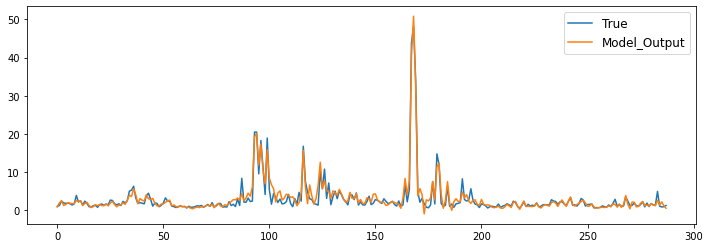

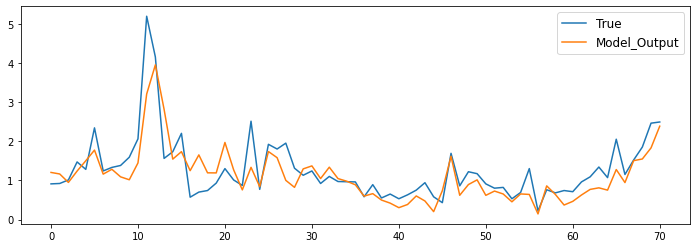

In [ ]:
kwargs_scripps_Jiting = {
  "wav_dict": [ {'wav_col': 'Chlorophyll (mg/m3)', 'wavelet_type': 'db4', 'level_num': 4} ],
  "cols_to_keep": ['Chlorophyll (mg/m3)'], 
  "shift_params": {'known_month': 1, 'predict_col_name': 'Chlorophyll (mg/m3)', 'features_use_current_observation': []}
}

df_scripps_only_wavelets = data_prep_Jiting(df_scripps, **kwargs_scripps_Jiting)
print(df_scripps_only_wavelets.columns)

hidden_layer, y_train, y_train_res, y_test, y_test_res = pipeline_ann_Jiting(df_scripps_only_wavelets)
  
# output result
print("hidden_layer: ", hidden_layer)
print_error(y_test, y_test_res)

# save result
df_test_result = pd.DataFrame(y_test_res, columns=['Prediction'])
df_test_result = df_test_result.reset_index(drop=True)

plot_line_chart_for_train_or_test_set(y_train, y_train_res)

plot_line_chart_for_train_or_test_set(y_test, y_test_res)

df_save_csv = pd.concat([df_save_for_plot, df_test_result], axis=1)
df_save_csv.to_csv('./Result/Only_Wavelet_ANN/Scripps.csv')

### Scripps LSTM

In [ ]:
df_scripps_all

,chla_for_predict,Nitrate (uM),Nitrite (uM),Phosphate (uM),Silicate (uM),Water Temperature,WDIR,WSPD,Chlorophyll (mg/m3)_d1,Chlorophyll (mg/m3)_d2,...,Nitrate (uM)_last,Nitrite (uM)_last,Phosphate (uM)_last,Silicate (uM)_last,Water Temperature_last,Chlorophyll (mg/m3)_d1_last,Chlorophyll (mg/m3)_d2_last,Chlorophyll (mg/m3)_d3_last,Chlorophyll (mg/m3)_d4_last,Chlorophyll (mg/m3)_a4_last
1,1.00,0.079772,0.129032,0.343434,0.386950,0.372881,0.765829,0.154554,0.883986,0.027808,...,0.041785,0.096774,0.212121,0.427921,0.584746,-0.242797,0.196015,0.041865,-0.037721,1.862638
2,1.23,0.014245,0.032258,0.252525,0.311077,0.745763,0.547789,0.159104,-0.715322,-0.042607,...,0.079772,0.129032,0.343434,0.386950,0.372881,0.883986,0.027808,-0.047619,-0.030765,1.876590
3,2.41,0.017094,0.032258,0.161616,0.356601,0.618644,0.523014,0.162358,-0.433239,-0.093061,...,0.014245,0.032258,0.252525,0.311077,0.745763,-0.715322,-0.042607,-0.110271,-0.024736,1.892935
4,1.90,0.020893,0.000000,0.101010,0.356601,0.805085,0.471188,0.201683,0.696377,-0.027557,...,0.017094,0.032258,0.161616,0.356601,0.618644,-0.433239,-0.093061,-0.135571,-0.019974,1.911845
5,1.80,0.008547,0.000000,0.131313,0.333839,0.855932,0.847341,0.244699,-0.035194,0.206756,...,0.020893,0.000000,0.101010,0.356601,0.805085,0.696377,-0.027557,-0.179933,-0.010722,1.931835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,1.15,0.226971,0.677419,0.333333,0.492413,0.313559,0.893536,0.315088,0.506269,0.059402,...,0.019943,0.096774,0.171717,0.295903,0.381356,-0.273000,-0.022419,0.054299,-0.207308,1.518427
356,1.52,0.056980,0.516129,0.222222,0.239757,0.338983,0.840222,0.336328,-0.443226,-0.018455,...,0.226971,0.677419,0.333333,0.492413,0.313559,0.506269,0.059402,-0.024364,-0.146409,1.655103
357,1.85,0.034188,0.290323,0.161616,0.216237,0.508475,0.879012,0.176077,0.026450,-0.236269,...,0.056980,0.516129,0.222222,0.239757,0.338983,-0.443226,-0.018455,-0.137626,-0.052023,1.801331
358,2.46,0.021842,0.193548,0.151515,0.261002,0.432203,0.793517,0.360584,0.098268,-0.148504,...,0.034188,0.290323,0.161616,0.216237,0.508475,0.026450,-0.236269,-0.299013,0.069979,1.958853


hidden_layer:  32
MSE:  0.18505242
RMSE:  0.4301772
MAPE:  25.388774275779724
Best length:  17


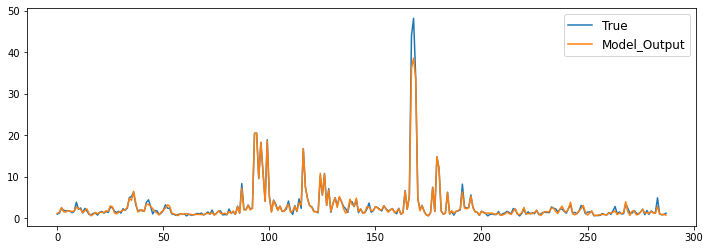

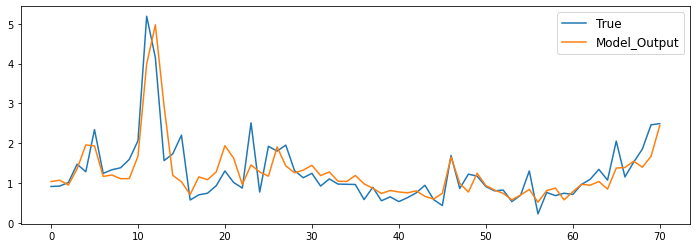

In [ ]:
df_import = get_feature_importance(df_scripps_all)
columns = df_import.index.to_list()

curr_mse = sys.maxsize

length = len(columns)
for vec_len in range((int)(0.5*length), length+3, 3):
  cols = columns[:vec_len] + ["chla_for_predict"]
  df_data = df_scripps_all[cols] 

  hidden_layer, y_train, y_train_res, y_test, y_test_res = pipeline_lstm_Jiting(df_data)
  err_mse = mean_squared_error(y_test, y_test_res)

  if err_mse < curr_mse:
    curr_mse = err_mse
    save_hidden_layer, save_y_train, save_y_train_res, save_y_test, save_y_test_res = hidden_layer, y_train, y_train_res, y_test, y_test_res
    best_length = vec_len


# output result
print("hidden_layer: ", save_hidden_layer)
print_error(save_y_test, save_y_test_res)
print("Best length: ", best_length)

# save result
df_test_result = pd.DataFrame(save_y_test_res, columns=['Prediction'])
df_test_result = df_test_result.reset_index(drop=True)

plot_line_chart_for_train_or_test_set(save_y_train, save_y_train_res)

plot_line_chart_for_train_or_test_set(save_y_test, save_y_test_res)

df_save_csv = pd.concat([df_save_for_plot, df_test_result], axis=1)
df_save_csv.to_csv('./Result/LSTM/Scripps.csv')